In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, utils, models
from torch.utils.data import DataLoader
import time 
import os
from tempfile import TemporaryDirectory
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [2]:
data_dir = 'dataset/gzip'

In [3]:
data_transform = {
    'train' : transforms.Compose([
        transforms.RandomRotation(10), #random rotation 10 degrees
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),

    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
}

In [4]:
image_datasets = {
    'train': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = True,
        download = True,
        transform = data_transform['train']
    ),

    'test': datasets.EMNIST(
        root = data_dir,
        split = 'balanced',
        train = False,
        download = True,
        transform = data_transform['test']
    )
}


In [5]:
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=64, shuffle=(x == 'train'))
    for x in ['train', 'test']
}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), cmap = 'gray')
    plt.show()

In [8]:
dataiterator = iter(dataloaders['train'])
images, labels = next(dataiterator)

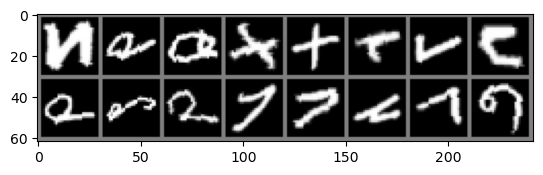

In [9]:
imshow(utils.make_grid(images[:16]))

In [10]:
#Define ResNet model

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [11]:
#Create instance of model
num_classes = len(image_datasets['train'].classes)
model = CNN(num_classes).to(device)

In [12]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
#scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
#Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [15]:
#Train model
num_epochs = 100
trained_model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

Epoch 0/2
----------
train Loss: 1.1988 Acc: 0.6330
test Loss: 0.5077 Acc: 0.8321

Epoch 1/2
----------
train Loss: 0.7569 Acc: 0.7546
test Loss: 0.4407 Acc: 0.8480

Epoch 2/2
----------
train Loss: 0.6677 Acc: 0.7810
test Loss: 0.4028 Acc: 0.8616

Training complete in 1m 13s
Best val Acc: 0.861649


In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()  
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10)) 

    with torch.no_grad(): 
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j].item()]}')
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) 
                    plt.show()
                    return
    model.train(mode=was_training)
    plt.show()
